<a href="https://colab.research.google.com/github/Desmyk/ADVMachineLearning/blob/main/Capstone_DeepL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import necessary libraries

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:23<00:00, 142MB/s]
100% 2.04G/2.04G [00:23<00:00, 92.8MB/s]


In [3]:
# unzip dataset
!unzip -q plantvillage-dataset.zip

In [3]:

# Load the dataset
dataset = '/content/plantvillage dataset'


Found 162916 files belonging to 3 classes.


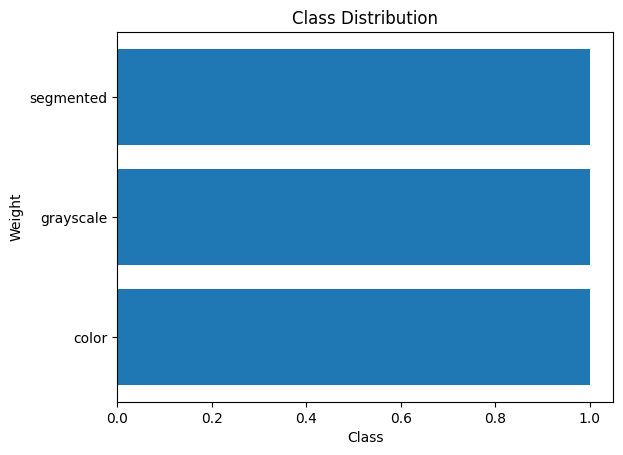

In [4]:
# Plot the class distribution
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/plantvillage dataset',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224)
)

class_names = dataset.class_names
num_classes = len(class_names)
class_weights = {i: 1.0 for i in range(num_classes)}

plt.barh(class_names, class_weights.values())
plt.xlabel('Class')
plt.ylabel('Weight')
plt.title('Class Distribution')
plt.show()

In [8]:
# Normalize the pixel values
# We normalize pixel values of the images to the range [0, 1].

dataset = dataset.map(lambda x, y: (x / 255.0, y))

# The transformation divides each pixel value by 255 to normalize it to the range [0, 1]

In [10]:
# We apply data augmentation techniques to increase diversity of the set

# Apply data augmentation
dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
dataset = dataset.map(lambda x, y: (tf.image.random_brightness(x, 0.2), y))
dataset = dataset.map(lambda x, y: (tf.image.random_contrast(x, lower=0.8, upper=1.2), y))

# The map function is used to apply a transformation to each element of the dataset
# The lambda function is used to define the transformation
# The transformation applies random flipping, brightness, and contrast to the images

In [14]:
# Let's develop a deepL model for wheat detection & disease classification

# Define the model architecture
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
# The Conv2D layer is used to add a convolutional layer
# The MaxPooling2D layer is used to add a max pooling layer
# The Flatten layer is used to flatten the output of the convolutional and pooling layers
# The Dense layer is used to add a dense layer

x = base_model.output
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [15]:
# compile the model with the Adam optimizer
# and categorical cross-entropy loss function.

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

In [ ]:
# We now can train model

# Train the model
model.fit(dataset, epochs=50, batch_size=32)

Epoch 1/50
 284/5092 ━━━━━━━━━━━━━━━━━━━━ 23:42:44 18s/step - categorical_accuracy: 0.3269 - loss: 1.1841

In [ ]:
# We evaluate the performance of the model using the test dataset.

# Evaluate the model
test_loss, test_acc = model.evaluate(dataset)
print('Test accuracy:', test_acc)